In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
from keras.metrics import MeanIoU, Accuracy

In [2]:
# unzip 2d images of lung CT
path = '2d_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_images')
    
# unzip 2d masks of lung CT
path = '2d_masks.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_masks')

In [3]:
# load tiff images
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


In [4]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ 1st arg: (# of numpy set(x_data, y_data), length of numpy set, height, width, color channel)

In [5]:
for i, img_path in enumerate(img_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    x_data[i] = img

# convert mask images to numpy arrays
for i, img_path in enumerate(mask_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    y_data[i] = img

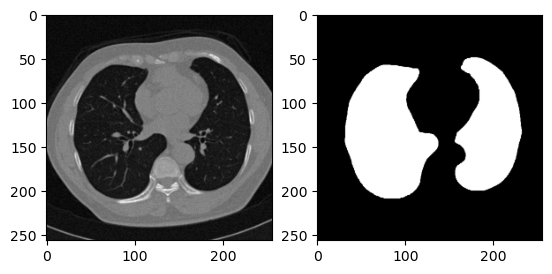

In [6]:
# scale image arrays
# scaling benefits learning process 
x_data /= 255
y_data /= 255

# display samples of image and mask in gray scale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[50].squeeze(), cmap='gray')
ax[1].imshow(y_data[50].squeeze(), cmap='gray')
# ^ since imshow takes 2d array, 3d array is squeezed down to 2d by removing single dimensional entry

In [7]:
# split dataset into train and validation datasets with 20% test portion
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

print(x_train.shape)
print(x_val.shape)
print(y_val.shape)
print(y_train.shape)

(213, 256, 256, 1)
(54, 256, 256, 1)
(54, 256, 256, 1)
(213, 256, 256, 1)


In [8]:
inputs = Input(shape=(256, 256, 1))

#Encoder Module
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Decoder module
u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

In [9]:
#define loss function
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_16 (Conv2D)             (None, 256, 256, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 1)  17          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 1,940,817
Trainable params: 1,940,817
Non-trainable params: 0
__________________________________________________________________________________________________


In [10]:
#train model
model_checkpoint = ModelCheckpoint('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/unet_1.h5', monitor='loss', save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=4, callbacks=[model_checkpoint, callback])

Epoch 1/10
54/54 [==============================] - 58s 938ms/step - loss: 0.7844 - accuracy: 0.6616
Epoch 2/10
54/54 [==============================] - 49s 907ms/step - loss: 0.3047 - accuracy: 0.8502
Epoch 3/10
54/54 [==============================] - 50s 925ms/step - loss: 0.1317 - accuracy: 0.9388
Epoch 4/10
54/54 [==============================] - 56s 1s/step - loss: 0.0979 - accuracy: 0.9458
Epoch 5/10
54/54 [==============================] - 50s 917ms/step - loss: 0.0771 - accuracy: 0.9516
Epoch 6/10
54/54 [==============================] - 47s 871ms/step - loss: 0.0704 - accuracy: 0.9536
Epoch 7/10
54/54 [==============================] - 47s 867ms/step - loss: 0.0594 - accuracy: 0.9557
Epoch 8/10
54/54 [==============================] - 47s 878ms/step - loss: 0.0552 - accuracy: 0.9562
Epoch 9/10
54/54 [==============================] - 47s 874ms/step - loss: 0.0487 - accuracy: 0.9571
Epoch 10/10
54/54 [==============================] - 47s 868ms/step - loss: 0.0468 - accuracy:

In [11]:
model.save('unet.bik')

INFO:tensorflow:Assets written to: unet.bik\assets


INFO:tensorflow:Assets written to: unet.bik\assets


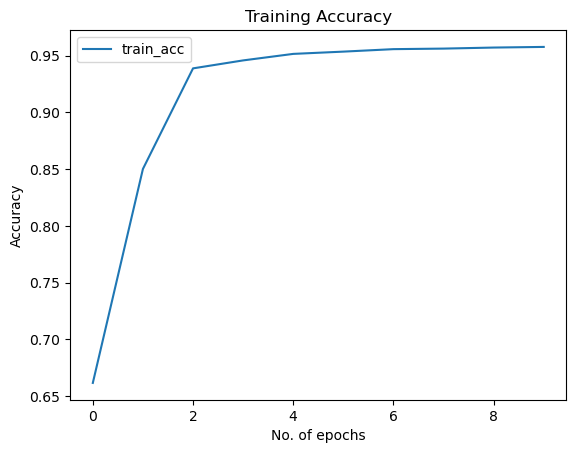

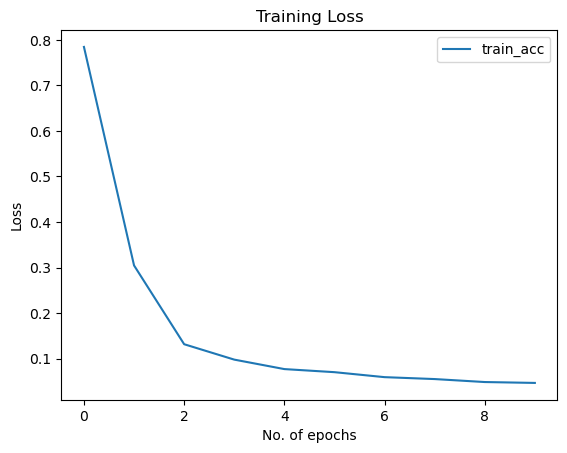

In [12]:
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.plot(history.history['loss'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

2/2 [==============================] - 11s 3s/step


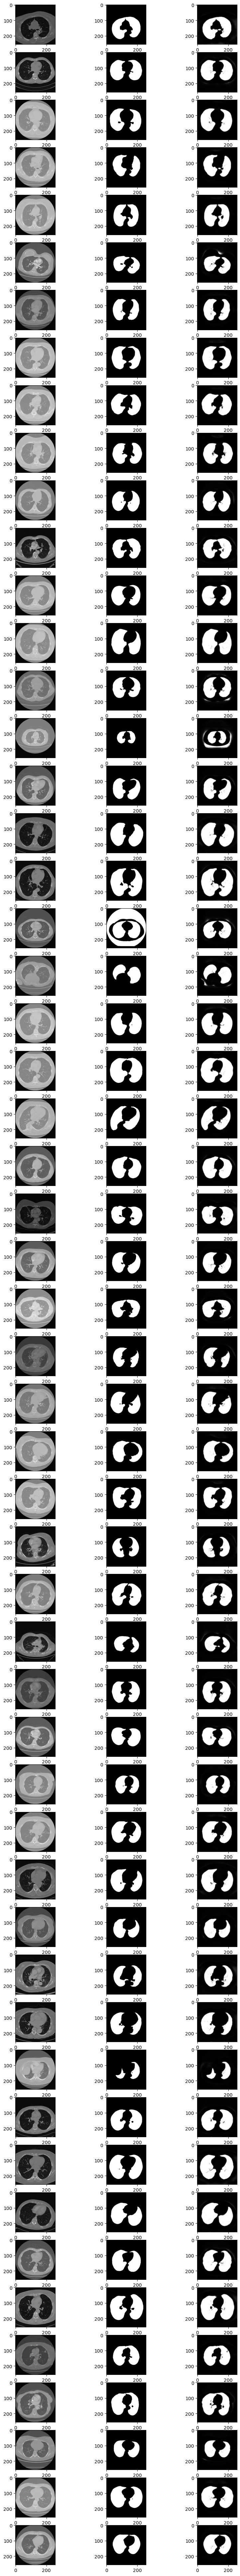

In [13]:
# predict segmentation
model.load_weights('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/unet_1.h5')
y_pred = model.predict(x_val)

# show results
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))
for i, pred in enumerate(y_pred):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

mean IoU =  0.39460543
acc =  0.98308057
Dice Coefficient: 0.96271116
Classification Report : 
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99   2733263
       Lungs       0.97      0.96      0.96    805681

    accuracy                           0.98   3538944
   macro avg       0.98      0.97      0.98   3538944
weighted avg       0.98      0.98      0.98   3538944

Cohen's Kappa =  0.9517691301496854


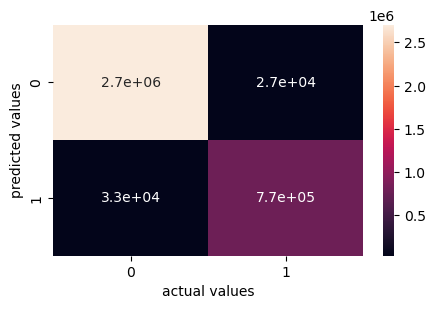

In [14]:
y_val_int = np.squeeze(y_val).astype(np.int32)
y_pred_int = np.squeeze(y_pred).astype(np.int32)

#MeanIoU
meaniou = MeanIoU(2)
meaniou.update_state(y_val_int, y_pred_int)
print('mean IoU = ', meaniou.result().numpy())
meaniou.reset_states()

y_val_binary = np.where(y_val > 0.5, 1, 0)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

#Accuracy
acc = Accuracy()
acc.update_state(y_val_binary, y_pred_binary)
print('acc = ', acc.result().numpy())
acc.reset_states()

#diceCoeff
intersection = tf.reduce_sum(tf.cast(y_val_binary * y_pred_binary, tf.float32))
sum_true = tf.reduce_sum(tf.cast(y_val_binary, tf.float32))
sum_pred = tf.reduce_sum(tf.cast(y_pred_binary, tf.float32))

dice_coeff = (2.0 * intersection + 1e-5) / (sum_true + sum_pred + 1e-5)
print("Dice Coefficient:", dice_coeff.numpy())

#Confusion matrix
cm = confusion_matrix(y_val_binary.flatten(), y_pred_binary.flatten(), labels=[0, 1])
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True)
plt.xlabel('actual values')
plt.ylabel('predicted values')

#Classification report
cr = classification_report(y_val_binary.flatten(), y_pred_binary.flatten(), target_names=["Background", "Lungs"])
print("Classification Report : ")
print(cr)

#Cohen kappa score
k = cohen_kappa_score(y_val_binary.flatten(), y_pred_binary.flatten())
print("Cohen's Kappa = ", k)

In [15]:
# Calculate Parameters
params = model.count_params()
print("Total Parameters:", params)

# Calculate FLOPs
from keras_flops import get_flops

flops = get_flops(model, batch_size=1)
print("Estimated FLOPs:", flops)

Total Parameters: 1940817
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Estimated FLOPs: 6039207936
